In [80]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import folium
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [81]:
data = pd.read_csv('../data/processed_data/preprocessed_data.csv')

In [82]:
data.head()

,props_pageProps_address_buildings_0_bathroomCondition,props_pageProps_address_buildings_0_buildingName,props_pageProps_address_buildings_0_externalWallMaterial,props_pageProps_address_buildings_0_heatingInstallation,props_pageProps_address_buildings_0_housingArea,props_pageProps_address_buildings_0_kitchenCondition,props_pageProps_address_buildings_0_numberOfFloors,props_pageProps_address_buildings_0_numberOfToilets,props_pageProps_address_buildings_0_roofingMaterial,props_pageProps_address_buildings_0_toiletCondition,props_pageProps_address_buildings_0_yearBuilt,props_pageProps_address_municipality_name,props_pageProps_address_coordinates_lat,props_pageProps_address_coordinates_lon,props_pageProps_address_events_0_at,props_pageProps_address_events_0_label,props_pageProps_dataLayer_virtualPagePath,lastPrice,sqm_price,years_from_today,years_from_today_weighted
0,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Letbetonsten,Varmepumpe,195.0,Eget køkken med afløb,1.0,3.0,Tagpap med lille hældning,Vandskyllende toilet i enheden,2017.0,Helsingør,56.015070,12.596564,2017-07-31 00:00:00+00:00,Fri handel,/adresse/kirsebaerbakken-1-3070-snekkersten-02...,5300000.0,27179.487179,6,36
1,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Centralvarme med én fyringsenhed,120.0,Eget køkken med afløb,1.0,1.0,Fibercement herunder asbest,Vandskyllende toilet i enheden,1970.0,Helsingør,55.993030,12.490787,2011-05-17 00:00:00+00:00,Fri handel,/adresse/axel-moellers-vej-2c-3490-kvistgaard-...,1900000.0,15833.333333,12,144
2,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Varmepumpe,162.0,Eget køkken med afløb,1.0,2.0,Betontagsten,Vandskyllende toilet i enheden,1932.0,Helsingør,55.992590,12.491281,2002-05-28 00:00:00+00:00,Fri handel,/adresse/axel-moellers-vej-5-3490-kvistgaard-0...,1848944.0,11413.234568,21,441
3,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Varmepumpe,98.0,Eget køkken med afløb,1.0,1.0,Tagpap med stor hældning,Vandskyllende toilet i enheden,1942.0,Helsingør,55.992680,12.490918,2023-08-22 00:00:00+00:00,Fri handel,/adresse/axel-moellers-vej-6-3490-kvistgaard-0...,2450000.0,25000.000000,0,0
4,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Træ,Centralvarme med én fyringsenhed,200.0,Eget køkken med afløb,1.0,2.0,Fibercement herunder asbest,Vandskyllende toilet i enheden,1967.0,Helsingør,56.073437,12.538015,2022-01-26 00:00:00+00:00,Fri handel,/adresse/alexander-svedstrups-vej-2-3140-aalsg...,5000000.0,25000.000000,1,1


In [90]:
# Preprocess the data once before the loop
k_means_data = data.drop(['props_pageProps_address_events_0_at', 'lastPrice', 'sqm_price', 'years_from_today',
                          'props_pageProps_address_coordinates_lat', 'props_pageProps_address_coordinates_lon',
                          'props_pageProps_dataLayer_virtualPagePath', 'props_pageProps_address_events_0_label'], axis=1)

# Selecting categorical and numerical columns
categorical_cols = k_means_data.select_dtypes(exclude=[np.number]).columns
numerical_cols = k_means_data.select_dtypes(include=[np.number]).columns

# One-Hot Encoding for categorical data
encoder = OneHotEncoder(sparse=False)
encoded_categorical_data = encoder.fit_transform(k_means_data[categorical_cols])

# Creating a DataFrame for encoded categorical data
new_columns = [f"{col}_{val}" for col, values in zip(categorical_cols, encoder.categories_) for val in values]
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=new_columns)

# Standardizing numerical data
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(k_means_data[numerical_cols])

# Creating a DataFrame for scaled numerical data
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_cols)

# Combining scaled numerical and encoded categorical data
combined_data = pd.concat([scaled_numerical_df, encoded_categorical_df], axis=1)

# Calculating the within-cluster sum of square
wcss = []

for k in range(1, 51):
    # Apply K-means clustering to the combined dataset
    kmeans = KMeans(n_clusters=k, random_state=0, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(combined_data)
    wcss.append(kmeans.inertia_)

/Users/shakirmshaker/Library/Mobile Documents/com~apple~CloudDocs/Skole/DTU/ComputationalTools/Project/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


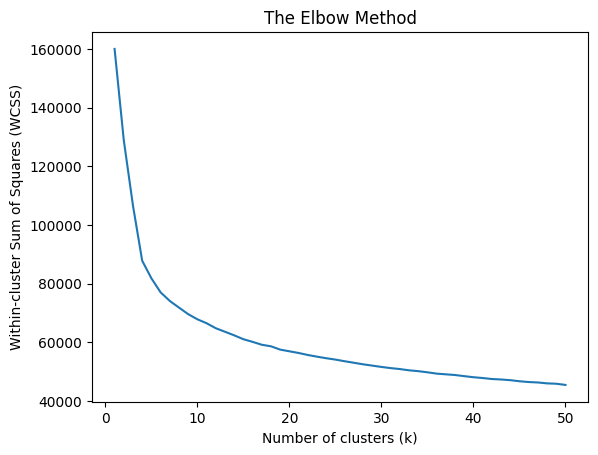

In [91]:
plt.plot(range(1, 51), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.show()

In [92]:
# Davies-Bouldin scores for different values of k
db_scores = []

# Range of k values to try
k_values = range(2, 51)  # Davies-Bouldin index isn't defined for k=1

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(combined_data)
    db_score = davies_bouldin_score(combined_data, cluster_labels)
    db_scores.append(db_score)

# Find the optimal k using Davies-Bouldin score
optimal_k = k_values[db_scores.index(min(db_scores))]

print(f"Optimal number of clusters (k): {optimal_k}")
print(f"Davies-Bouldin Score for k={optimal_k}: {min(db_scores)}")

Optimal number of clusters (k): 5
Davies-Bouldin Score for k=5: 1.276810290971997


In [97]:
sorted(db_scores)[:10]

[1.276810290971997,
 1.3352099086029237,
 1.4156657196006253,
 1.4676387012458703,
 1.6506825777269378,
 1.7896688189252261,
 1.807067357797695,
 2.0542260682456357,
 2.0709287239178003,
 2.07205922126063]

In [94]:
kmeans = KMeans(n_clusters=optimal_k, random_state=0, init='k-means++', max_iter=300, n_init=10)
clusters = kmeans.fit_predict(combined_data)
data['cluster'] = clusters

In [95]:
# Assign a unique color to each cluster
palette = sns.color_palette("tab10", k).as_hex()
data['color'] = data['cluster'].apply(lambda x: palette[x])

# Create a new map for the combined dataset
map_center_lat, map_center_lon = data['props_pageProps_address_coordinates_lat'].mean(), data['props_pageProps_address_coordinates_lon'].mean()
combined_map = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=7)

# Add the properties to the combined map
for _, row in data.iterrows():
    folium.CircleMarker(
        location=[row['props_pageProps_address_coordinates_lat'], row['props_pageProps_address_coordinates_lon']],
        radius=5,
        color=row['color'],
        fill=True,
        fill_color=row['color']
    ).add_to(combined_map)

# Save the new map
combined_map_file_path = f'../plots/{"Denmark"}_property_map.html'
combined_map.save(combined_map_file_path)
combined_map_file_path

'../clustering_maps/Denmark_property_map.html'

In [96]:
data.to_csv('../data/processed_data/clustered_data.csv', index = False)